# 1-D Heat Equation with Albini's Boundary Conditions



The script below was used to generate the plots included in this notebook. Individual pieces of the code will be explained in detail below.

**Warning:** running this script takes a very long time; if you need to do this, please run it in a python shell (rather than this notebook) and give it a few hours.

In [ ]:
from fenics import *
from scipy.special import erfc
import numpy as np
import matplotlib.pyplot as plt

# Object to describe boundary (FEniCS understands these)
class Surface(SubDomain):
    def inside(self, x, on_boundary):
        return(near(x[0], x_min, tol) and on_boundary) #surface boundary gets heat

# Function to describe Dirichlet boundary
def internal_boundary(x, on_boundary):
    return(near(x[0], x_max, tol) and on_boundary) #inner boundary is cold

def generate_alpha():
    """
    Create the alpha used by the analytical solution
    NOTE: This appears to work really well, but it's so simple it worries me.
    Parameters: None (variables must be declared)
    Returns: alpha (float)
    """
    return(k / 1)

def analytical_temperature_at_time(t, temp_f, temp_a, nx):
    """
    analytical solution to the problem:
        -treat it strictly as a surface convection problem (p.314 of bergman et al)
        -NOTE it seems like a and dt are closely tied; can we get a function that sets a?
    Parameters:
        t:  time iteration (float)
        temp_f:  fire temperature (float)
        temp_a:  ambient temperature (float)
    Returns:
        vals:  list of temperatures (floats)
    """
    temp_f = float(temp_f)
    temp_a = float(temp_a)
    a = generate_alpha()
    vals = []
    xs = np.linspace(x_min, x_max, nx+1)
    for x in xs:
        val = (temp_f - temp_a) * (erfc(x/(2*np.sqrt(a*t))) \
                                    - (np.exp(((h*x)/k) + ((h*h*a*t)/(k*k)))) \
                                    * (erfc((x/(2*np.sqrt(a*t))) + ((h*np.sqrt(a*t))/k)))) \
                                + temp_a
        vals.append(val)
    return(vals)

def compare_FEM_to_analytical(dx, dt, neumann_bc="explicit", chase_plot=False, range_error=False):
    """
    Perform a FEniCS simulation of the heat equation with Albini's boundary condition
    and compare its results against an analytical solution to get the error.

    Parameters:
        dx:  the distance between elements on the x-axis (float)
        dt:  the distance between elements in time (float)
        neumann_bc:  "implicit" uses the surface temperature of the current iteration (u)
                     "explicit" uses the surface temperature of the previous iteration (u_n)
        chase_plot:  show the temperature across the simulation as it runs (both FEM and analytical)
        range_error:  show the error range across the simulation at its end. NOTE: buggy as hell.
    """
    num_steps = int(T / dt)
    nx = int((x_max - x_min) / dx)

    # Temperature variables
    temp_f = Constant("500") #fire
    temp_a = Constant("23.5") #ambient (room)
    temp_s = temp_a #surface

    # Create mesh and define function space
    mesh = IntervalMesh(nx, x_min, x_max)
    V = FunctionSpace(mesh, 'CG', 1)

    # Define initial value
    u_n = interpolate(temp_a, V)

    #Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)

    # Set up domain for neumann boundary condition
    boundary_markers = FacetFunction('size_t', mesh)
    surface = Surface() #make
    surface.mark(boundary_markers, 0) #mark
    domain_markers = CellFunction('size_t', mesh) #describe full domain (is this needed?)

    # Describe the domain for ds and dx (neumann boundary and full domain, respectively)
    dx = Measure('dx', domain=mesh, subdomain_data=domain_markers)
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    # Describe the domain for the dirichlet boundary condition (xmax)
    bc = DirichletBC(V, temp_a, internal_boundary)

    # Describe the heat source
    source = Expression('h * (temp_f - temp_s)', h=h, temp_f=temp_f, temp_s=temp_s, degree = 2)

    # = ((current state - previous state)/dt) + (heat dissipation in obj) - (heat source on boundary)
    if(neumann_bc == "explicit"):
        F = (((u-u_n)*v)/dt)*dx + ((inner(k*grad(u),grad(v))) * dx) - (source * v) * ds
    elif(neumann_bc == "implicit"):
        F = (((u-u_n)*v)/dt)*dx + ((inner(k*grad(u),grad(v))) * dx) - (((h *(temp_f - u)) * v) * ds)
    else:
        print("hit an unknown neumann boundary condition %s." % (neumann_bc))
        raise
    a, L = lhs(F), rhs(F)

    # Time-stepping
    u = Function(V) #re-declare u as per docs
    u.assign(temp_a )
    t = 0
    ts = []
    diffs = []
    for n in range(num_steps):
        # Update current time
        t += dt
        # Calculate analytical solution at this time step
        compare = analytical_temperature_at_time(t, temp_f, temp_a, nx)
        # Compute solution
        G.user_parameters["temp_s"] = u
        solve(a == L, u, bc)
        # Get the values from the fenics Function
        values = np.array(Function.vector(u))[::-1]
        # Generate the coordinates of the mesh with a linspace
        coord = np.linspace(x_min, x_max, nx+1)
        # Get a sum of squared differences to see what errors look like
        sum_sq_diff = sum((values - compare)**2)
        # Append time, sum_sq_diff to list for plotting
        ts.append(t)
        diffs.append(sum_sq_diff)
        # Update neumann boundary condition expression with new surface temp (thanks jake)
        temp_s = u(0)
        source.user_parameters["temp_s"] = Constant(temp_s)
        print('t = %.2f; surface temp = %.2f; analytical temp = %.2f' % (t,temp_s,compare[0]))
        # Update previous solution
        u_n.assign(u)
        if(chase_plot):
            # Clear the figure
            ax.clear()
            # Now plot all this stuff as a matplotlib pyplot instead so we can overlay multiple lines
            ax.plot(coord, values, color="red", label = "Albini")
            ax.plot(coord, compare, color="blue", label = "Analytical")
            # Window dressing:
            ax.set_title("Analytical vs. Albini Heat Equations")
            ax.legend()
            # Draw it all
            fig.canvas.draw()
            fig.show()
    if(range_error): #show the error across the whole simulation
        ax.clear()
        ax.set_title("Sum of Squared Differences")
        ax.plot(ts, diffs, color = "green")
        plt.show()
        interactive()
        ax.clear()
    errors = sum(diffs)
    return(errors)

# End function declarations

# Heat transfer variables
#h -> parameter that describes heat transfer from flame to object (becomes unstable if large and k is small)
h = 1.0
#k -> kappa parameter; describes heat transfer inside object (becomes unstable if small)
k = 8.000 #TODO as above

#the tolerance for float comparison (a little lenient)
tol = 1E-12

# Set up the matplotlib figure
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

# Time variables
T = 20.0 #final time
totals = []
# Distance variables
x_min = 0.0 #edge of object which is heated
x_max = 100.0 #distance into object

dts = np.logspace(-4, 1, 10)
dxs = np.logspace(-4, 1, 10)

# Testing dt -> set a fixed dx NOTE
dx = 0.1

errors = []
for dt in dts:
    errors.append(compare_FEM_to_analytical(dx,dt,neumann_bc="explicit"))
# Save plot and move on
ax.clear()
ax.set_title("dt vs. error: explicit")
plt.xlabel("dt")
plt.ylabel("Summed sum of squared differences")
ax.loglog(dts, errors)
fig.savefig('dt_explicit.png')

errors = []
for dt in dts:
    errors.append(compare_FEM_to_analytical(dx,dt,neumann_bc="implicit"))
# Save plot and move on
ax.clear()
ax.set_title("dt vs. error: implicit")
plt.xlabel("dt")
plt.ylabel("Summed sum of squared differences")
ax.loglog(dts, errors)
fig.savefig('dt_implicit.png')

# Testing dx -> set a fixed dt NOTE
dt = 0.01

errors = []
for dx in dxs:
    errors.append(compare_FEM_to_analytical(dx,dt,neumann_bc="explicit"))
# Save plot and move on
ax.clear()
ax.set_title("dx vs. error: explicit")
plt.xlabel("dx")
plt.ylabel("Summed sum of squared differences")
ax.loglog(dxs, errors)
fig.savefig('dx_explicit.png')

errors = []
for dx in dxs:
    errors.append(compare_FEM_to_analytical(dx,dt,neumann_bc="implicit"))
# Save plot and move on
ax.clear()
ax.set_title("dx vs. error: implicit")
plt.xlabel("dx")
plt.ylabel("Summed sum of squared differences")
ax.loglog(dxs, errors)
fig.savefig('dx_implicit.png')

## Description of the script

### Functions and objects

##### Surface
The *surface* object serves to designate the boundary on which Albini's boundary condition (a Neumann BC) operates. In this case, a 1-D model of the heat equation in which heat proceeds from the surface of a semi-infinite solid towards its center, this surface is simply the first element in the analysis.

##### internal_boundary
The *internal boundary* serves to designate the Dirichlet boundary condition. We assume that the semi-infinite solid's internal boundary (infinitely far from the surface) is always at the ambient temperature of the system. Since this is a 1-D model, this boundary applies to the last element in the analysis.

##### generate_alpha
The analytical solution uses a coefficient $\alpha$ to describe thermal diffusivity; it interacts with the coefficients $h$ and $k$ to describe physical attributes of the medium. We try to neutralize this value since our simulation doesn't really consider it.

##### analytical_temperature_at_time
From Bergman et al. page 314: there is an analytical solution to the heat equation across a semi-infinite solid from a source of convection; we compare our simulation against this value in order to verify its accuracy. The analytical solution is:

$\frac{T(x,t) - T_i}{T_{\infty}-T_i} = erfc(\frac{x}{2\sqrt{\alpha t}}) - [exp(\frac{hx}{k} + \frac{h^2\alpha t}{k^2})][erfc(\frac{x}{2\sqrt{\alpha t}} + \frac{h \sqrt{\alpha t}}{k})]$

##### compare_FEM_to_analytical
Runs the simulation and compares it to the analytical solution. It has parameters to specify whether plotting should be done; it returns the summed error between the systems for comparison.

##### Rest of the script
Specifies the constants $h$ and $k$, the tolerance for comparing floating point numbers, the endpoints for the simulation (both spatial and temporal) , sets up the matplotlib display, and then calls compare_FEM_to_analytical() to generate data points. It saves the error plots rather than displaying them since it takes a while to run.

### Implicit and Explicit Solutions
The following solutions are derived from a standard backward Euler finite differences approximation (to discretize the problem) followed by formulation into the weak form (to make it solvable by FEM). We allow FEniCS to place terms where they belong in the equation.

#### Explicit
$F = \int_{\Omega} \frac{u^{n+1} - u^{n} } {dt}\ v\ dx + \int_{\Omega} k \frac{\partial u}{\partial x}\frac{\partial v}{\partial x}\ dx - \int_{\Gamma_N} h\ (u^{n} - T_s)\ ds$

#### Implicit
$F = \int_{\Omega} \frac{u^{n+1} - u^{n} } {dt}\ v\ dx + \int_{\Omega} k \frac{\partial u}{\partial x}\frac{\partial v}{\partial x}\ dx - \int_{\Gamma_N} h\ (u^{n+1} - T_s)\ ds$

Where the boundary condition on the integral $ds$ is of the form:
$h_{eff}\ (T_f - T_s) = \frac{dq\prime\prime}{dt} = -k\ \frac{\partial}{\partial x}\ T\ \ on\ \Gamma_N^i\ ,\ i = 0$

This means that terms expressed along the interval $\Gamma_N$ are 0 except at the outer boundary (the source of heat) where they are proportional to the difference of the fire temperature and the surface temperature; these terms represent the *heat flux*.

#### Error plots

For these plots, the following information may be useful:
h = 1
k = 8
dx = 0.1 (when testing dt)
dt = 0.01 (when testing dx)
Fire temp = 500
Ambient temp = 23.5

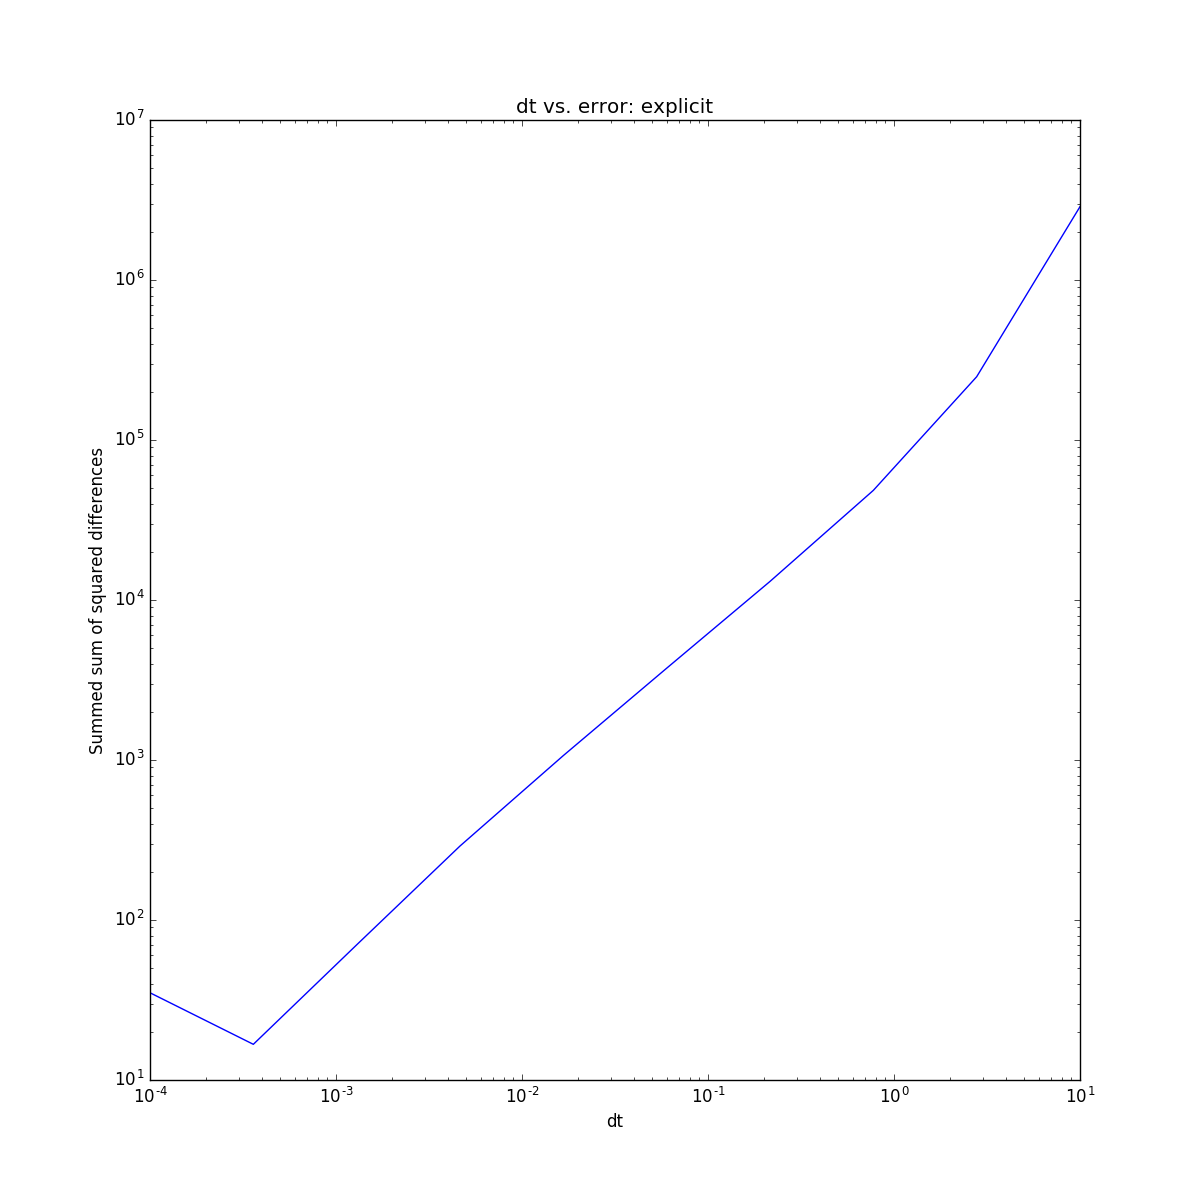
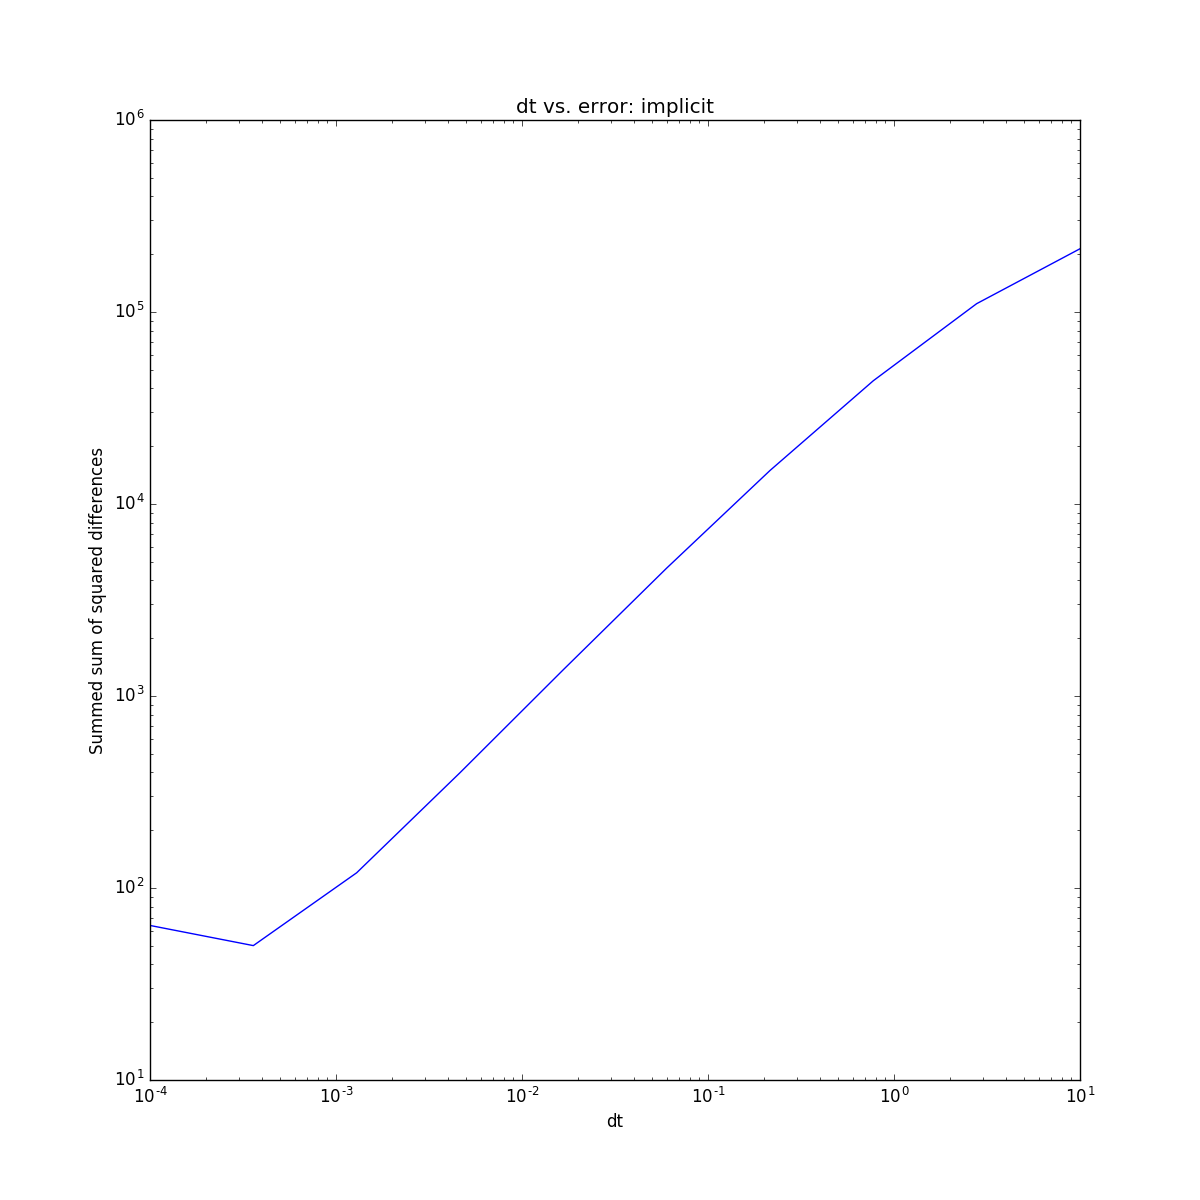


Surface temperature as a function of time:

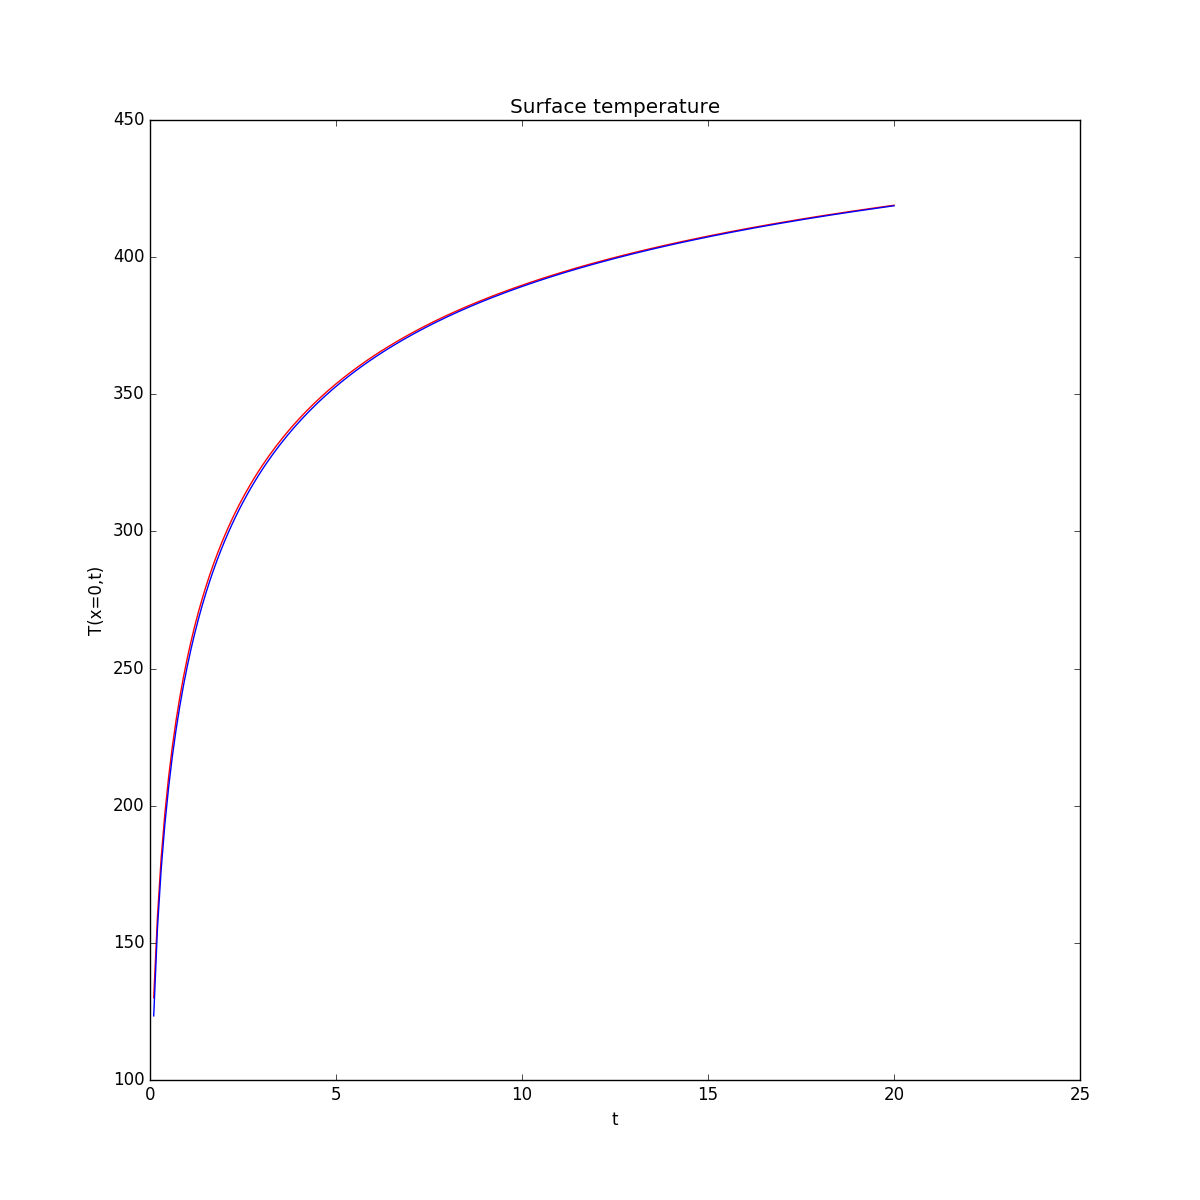